# RandomForest but with Rule (AQ algorithm)

Sample datasets are in the `example_data` folder

## Dataset: `student-alcohol_uma.csv`

### Loading the needed libraries

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [26]:
import numpy as np
from core.forest import Forest
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

### Training and testing

In [ ]:
all_stats = []

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

data = np.genfromtxt(fname="example_data/student-alcohol_uma.csv", delimiter=";", dtype=str)
X, y = data[:,:28], data[:,28:]

for _ in range(5):
    cv = KFold(n_splits=10, shuffle=True)
    for train_ix, test_ix in cv.split(X):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        forest = Forest(n_tree=200, train_x=X_train, train_y=y_train)
        score = []
        results = []
        print("Testing...")
        for test_x in tqdm(X_test):
            result, prec = forest.predict(test_x)
            results.append(result.tolist())
            score.append(prec)

        test_y = y_test

        fpr, tpr, _ = metrics.roc_curve(test_y, score, pos_label=['1'])

        stats = {}
        stats["acc"] = metrics.accuracy_score(test_y, results)
        stats["precision"] = metrics.precision_score(test_y, results, pos_label='1')
        stats["recall"] = metrics.recall_score(test_y, results, pos_label='1')
        stats["f1_score"] = metrics.f1_score(test_y, results, pos_label='1')
        stats["auc"] = metrics.auc(fpr, tpr)
        stats["fpr"] = fpr
        stats["tpr"] = tpr
        stats["cm"] = metrics.confusion_matrix(test_y,results)


        interp_tpr = np.interp(mean_fpr, stats["fpr"], stats["tpr"])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(stats["auc"])

        all_stats.append(stats)
    

In [12]:
def stats(dict_list, key):
    list = [el[key] for el in dict_list]
    np_list = np.array(list)
    return np.mean(np_list), np.std(np_list)

def get_min_and_max(dict_list, key):
    list = [el[key] for el in dict_list]
    return list.index(min(list)), list.index(max(list))


### Result

In [ ]:
#mean and std for acc
stats(all_stats, "acc")

In [ ]:
#mean and std for precision
stats(all_stats, "precision")

In [ ]:
#mean and std for f1_score
stats(all_stats, "f1_score")

In [16]:
#worst and best index by acc
min_v_acc, max_v_acc = get_min_and_max(all_stats, "acc")
min_v_auc, max_v_auc = get_min_and_max(all_stats, "auc")

### Worst and best acc

In [ ]:
all_stats[min_v_acc]

In [ ]:
all_stats[max_v_acc]

### ROC Mean

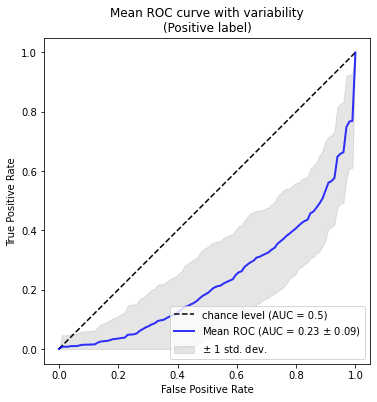

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

### Confusion Matrix for worst and best

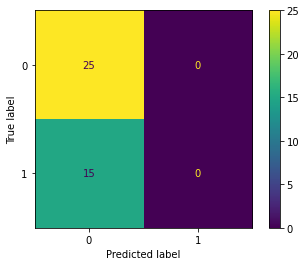

In [20]:
pcm = metrics.ConfusionMatrixDisplay(confusion_matrix=all_stats[min_v_acc]["cm"])
pcm.plot()
plt.show()

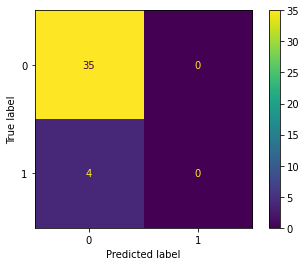

In [21]:
pcm = metrics.ConfusionMatrixDisplay(confusion_matrix=all_stats[max_v_acc]["cm"])
pcm.plot()
plt.show()

### Compare with classic RandomForest

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

ohe = OneHotEncoder()
all_stats = []

data = np.genfromtxt(fname="example_data/student-alcohol_uma.csv", delimiter=";", dtype=str)
X = ohe.fit_transform(data[:,:28])
y = np.array(data[:,28:]).ravel().astype(int)

for _ in range(5):
    cv = KFold(n_splits=10, shuffle=True)
    for train_ix, test_ix in cv.split(X):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        rf=RandomForestClassifier(n_estimators=200)
        rf.fit(X_train,y_train)


        results=rf.predict(X_test)

        test_y = y_test


        stats = {}
        stats["acc"] = metrics.accuracy_score(test_y, results)
        stats["precision"] = metrics.precision_score(test_y, results)
        stats["recall"] = metrics.recall_score(test_y, results)
        stats["f1_score"] = metrics.f1_score(test_y, results)
        stats["cm"] = metrics.confusion_matrix(test_y,results)

        all_stats.append(stats)

In [21]:
def stats(dict_list, key):
    list = [el[key] for el in dict_list]
    np_list = np.array(list)
    return np.mean(np_list), np.std(np_list)

def get_min_and_max(dict_list, key):
    list = [el[key] for el in dict_list]
    return list.index(min(list)), list.index(max(list))

In [ ]:
stats(all_stats, "acc")

In [ ]:
stats(all_stats, "precision")

In [ ]:
stats(all_stats, "recall")

In [ ]:
stats(all_stats, "f1_score")

In [17]:
min_v_acc, max_v_acc = get_min_and_max(all_stats, "acc")

In [ ]:
all_stats[min_v_acc]

In [ ]:
all_stats[max_v_acc]

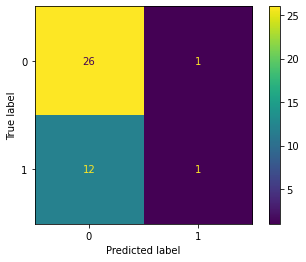

In [12]:
pcm = metrics.ConfusionMatrixDisplay(confusion_matrix=all_stats[min_v_acc]["cm"])
pcm.plot()
plt.show()

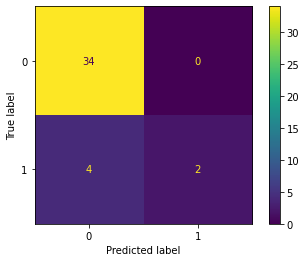

In [13]:
pcm = metrics.ConfusionMatrixDisplay(confusion_matrix=all_stats[max_v_acc]["cm"])
pcm.plot()
plt.show()